## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import math
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_images(images, label=None, n_cols=5, cmap=None):
    """
    plot images in n_cols columns
    :param images 
    :param label image labels
    :param n_cols number of columns
    """
    n_rows = math.ceil(len(images)/n_cols)
 
    plt.figure(figsize=(20, n_rows*10/n_cols))   
    for i,image in enumerate(images):
        #image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        if label != None:
            plt.title("Output " + str(label[i]))
        plt.imshow(image, aspect='equal', cmap=cmap)
    plt.show()

def plot_compare_images(left_images, right_images, cmap=None):
    mixed_images = list(itertools.chain.from_iterable(zip(left_images,right_images)))
    plot_images(mixed_images, n_cols=2, cmap=cmap)
    
def plot_histogram(labels, n_labels):
    """
    Exploration of the label distribution
    """
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
cal_files = glob.glob('../camera_cal/calibration*.jpg')
# Make a list of test images
test_files = glob.glob('../test_images/*.jpg')

corner_images = []

# Step through the list and search for chessboard corners
for fname in cal_files:
    img = plt.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_images.append(img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## And so on and so forth...

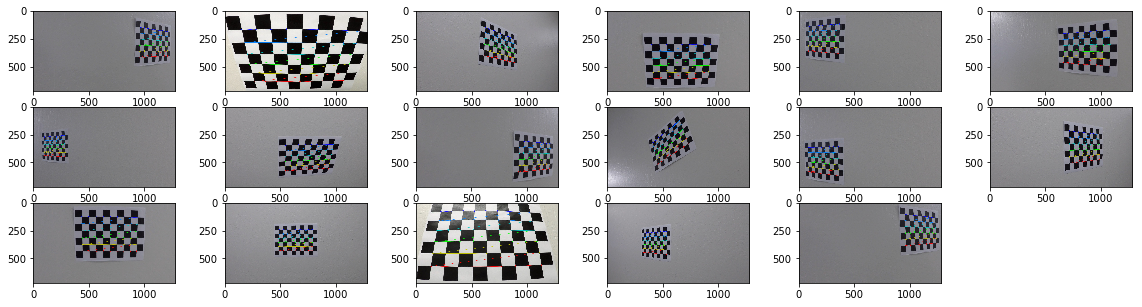

In [4]:
plot_images(corner_images, n_cols=6)

In [5]:
#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

cal_images = []
cal_distorted_images = []
for fname in cal_files:
    img = plt.imread(fname)
    cal_distorted_images.append(img)
    cal_images.append(cv2.undistort(img, mtx, dist, None, mtx))

test_images = []
for fname in test_files:
    img = plt.imread(fname)
    test_images.append(cv2.undistort(img, mtx, dist, None, mtx))

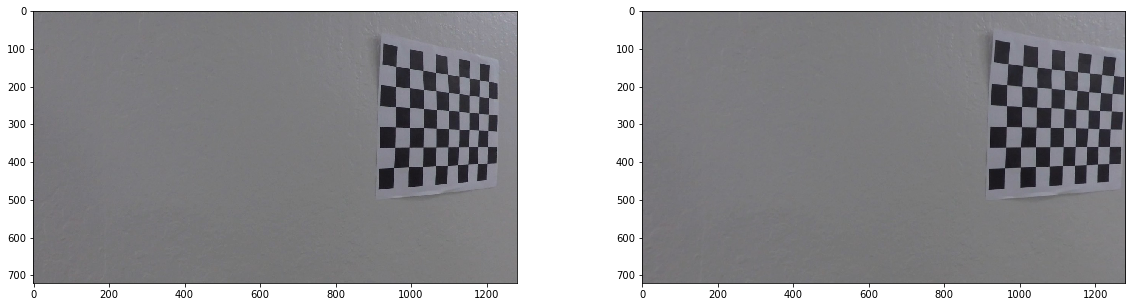

In [49]:
plot_compare_images(cal_distorted_images[0:1], cal_images[0:1])

In [63]:

def warp(img):
    '''
    '''
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [64]:
test_warped = [warp(img)[0] for img in test_images]

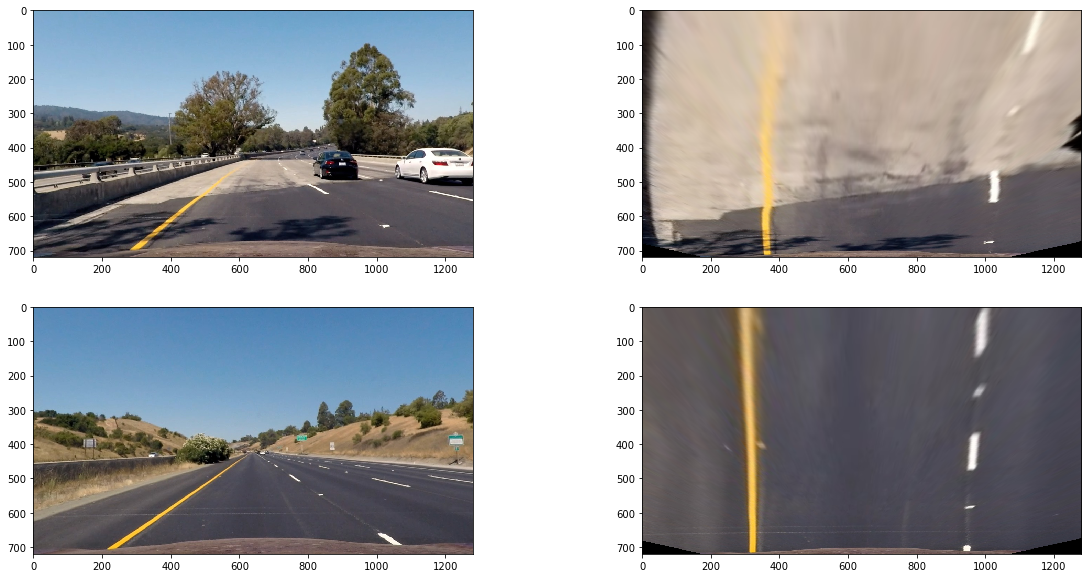

In [65]:
#print(test_warped[0].shape)
plot_compare_images(test_images[0:2], test_warped[0:2])

In [24]:
def select_color_code(func):
    def wrapper(img, code, *args, **kwargs):
        if code != None:
            img = cv2.cvtColor(img, code)
        func(img)
    return wrapper

def select_channel(img, channel=0):
    return None

                    
def channel_select(img, thresh=(0, 255), channel=2, code=cv2.COLOR_RGB2HLS):
    '''
    Function that thresholds the desired channel of selected color space 
    :param img: RGB input image
    :param thresh: threshold tupel from 0..255. thresh[0] < pixel <= thresh[1] are included
    :param channel: select color channel (e.g. H=0, L=1, S=2)
    :param code: 
    '''
    # use other color space than the original one
    if code != None:
        img = cv2.cvtColor(img, code)
    # select channel
    channel = img[:,:,channel]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1  
    return binary_output


def abs_sobel(sobelx, sobely):
    '''
    Take the absolute values of the sobel gradient and add/scale them    
    '''
    abs_sobel = np.absolute(sobelx) + np.absolute(sobely)
    # Rescale back to 8 bit integer
    return np.uint8(255*abs_sobel/np.max(abs_sobel))   

def mag_sobel(sobelx, sobely):
    '''
    Take the magnitude value of the sobel gradients and scale them   
    '''
    magn = np.sqrt(sobelx**2 + sobely**2)
    # Rescale back to 8 bit integer
    return np.uint8(255 * magn/np.max(magn))

def dir_sobel(sobelx, sobely):
    '''
    Use arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    '''
    return np.arctan2(np.absolute(sobelx), np.absolute(sobely))    

def sobel_thresh(img, thresh=(0,255), sobel_kernel=3, orient='xy', func=abs_sobel):
    '''
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray[:,:,0].shape)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient == 'x':
        sobely = 0
    elif orient == 'y':
        sobelx = 0
    # apply function on sobel values, e.g. magnitude, direction
    scaled_sobel = func(sobelx, sobely)   
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output = cv2.adaptiveThreshold(scaled_sobel,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    # Return the result
    return binary_output


def stack_binaries(first, second):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    return np.dstack(( np.zeros_like(first), first, second))

def combine_binaries(first, second):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(first)
    combined_binary[(first == 1) | (second == 1)] = 1
    return combined_binary

In [37]:
h_test_binaries = [channel_select(img, thresh=(90,225), channel=0) for img in test_images]
l_test_binaries = [channel_select(img, thresh=(90,225), channel=1) for img in test_images]
s_test_binaries = [channel_select(img, thresh=(90,225), channel=2) for img in test_images]
r_test_binaries = [channel_select(img, thresh=(225,255), channel=0, code=None) for img in test_images]

mag_test_binaries = [sobel_thresh(img, thresh=(50,100),func=mag_sobel) for img in test_images]
#dir_test_images = [sobel_thresh(img, thresh=(0.7, 1.2),func=dir_sobel) for img in test_images]
abs_test_binaries = [sobel_thresh(img, thresh=(15, 255),func=abs_sobel, orient='x', sobel_kernel=3) for img in test_images]
r_abs_stack_binaries = [stack_binaries(r, abs) for r,abs in zip(r_test_binaries, abs_test_binaries)]
print(abs_test_binaries[0].shape)
r_abs_comb_test_binaries = [combine_binaries(r, abs) for r,abs in zip(r_test_binaries, abs_test_binaries)]

(720, 1280)


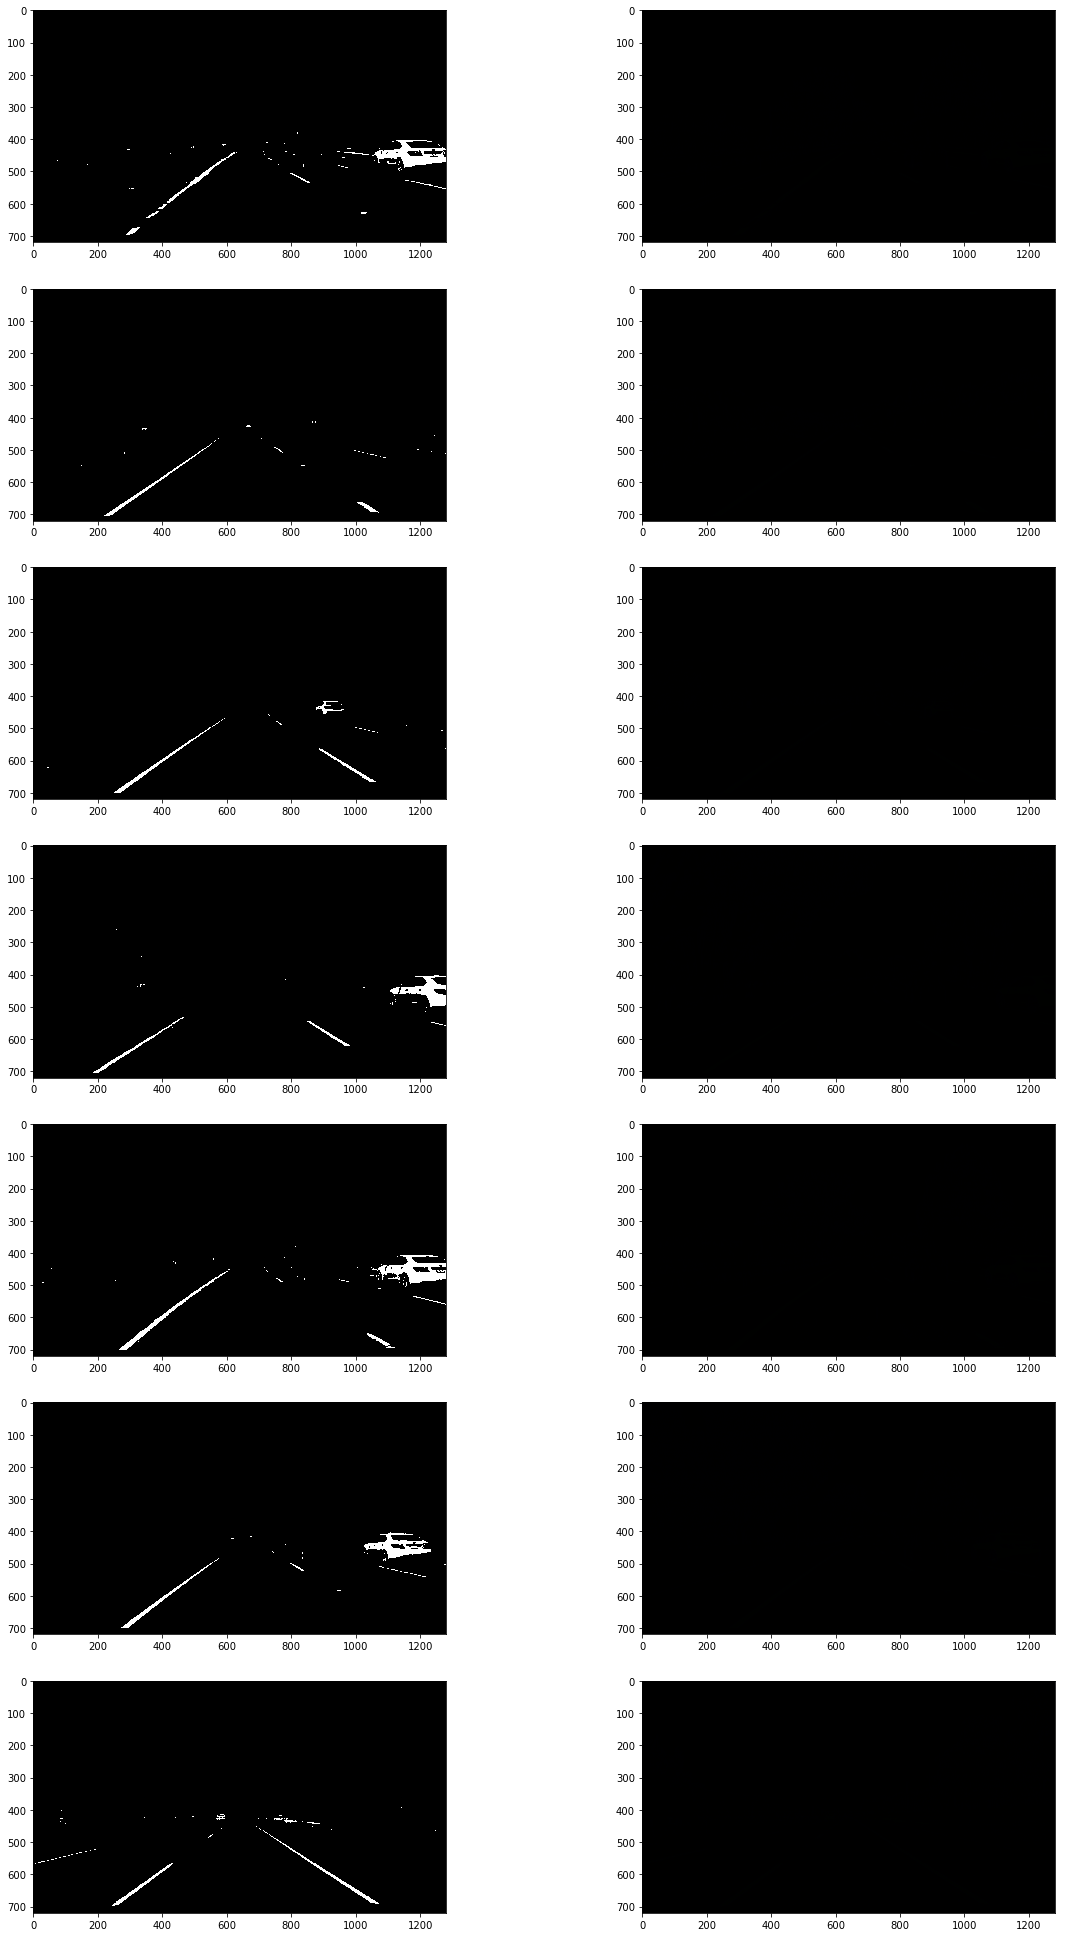

In [47]:
plot_compare_images(r_test_binaries[0:-1], r_abs_test_binaries[0:-1], cmap='gray')

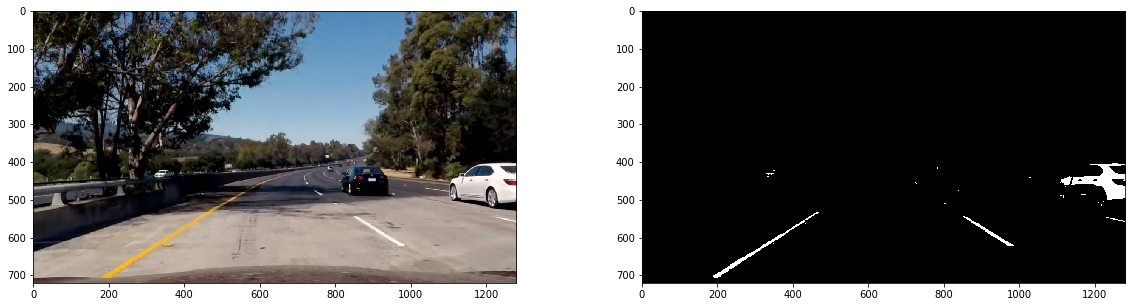

In [27]:
plot_compare_images(test_images[-2:-1], r_test_binaries[-2:-1], cmap='gray')

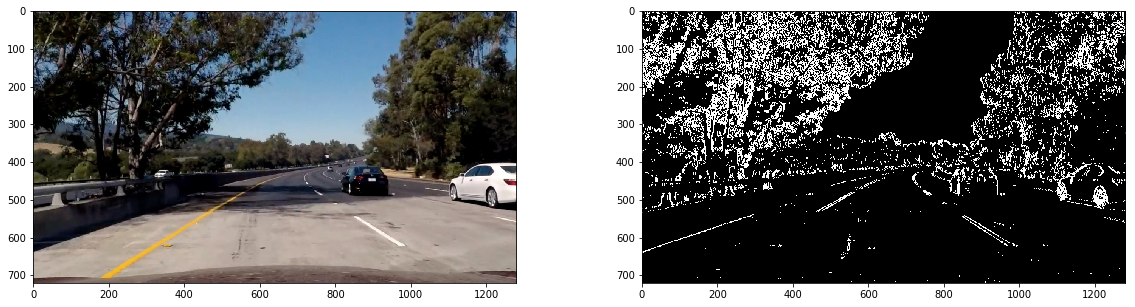

In [28]:
plot_compare_images(test_images[-2:-1], abs_test_binaries[-2:-1], cmap='gray')